In [1]:
%autoawait


IPython autoawait is `on`, and set to use `asyncio`


In [2]:
import asyncio
import os
from dotenv import load_dotenv
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
logging.getLogger("httpx").setLevel(logging.WARNING)

load_dotenv()


True

In [3]:
API_KEY = os.getenv("CONTEXTUAL_API_KEY")
BASE_URL = os.getenv("CONTEXTUAL_BASE_URL")


In [4]:
from contextual import ContextualAI

api_key = os.environ.get("CONTEXTUAL_API_KEY")
client = ContextualAI(
    api_key=API_KEY#, base_url=BASE_URL,
)
client


In [5]:
# Check if datastore exists
datastores = client.datastores.list()
existing_datastores = [ds for ds in datastores]

existing_datastores


[Datastore(id='1b36fb6b-50ea-405e-a2fd-bf7742dabc1d', created_at=datetime.datetime(2025, 5, 25, 21, 46, 48, 957255), name='pacp', datastore_type='UNSTRUCTURED', configuration={}, is_activated=True)]

In [6]:
def get_datastore_by_name(name):
    return next((ds for ds in client.datastores.list() if ds.name == name), None)


In [7]:
if datastore := get_datastore_by_name("pacp"):
    logger.info(f"Using existing datastore with ID: {datastore.id}")  
else:
    datastore = client.datastores.create(name="pacp")
    logger.info(f"Created new datastore with ID: {datastore.id}")



INFO:__main__:Using existing datastore with ID: 1b36fb6b-50ea-405e-a2fd-bf7742dabc1d


In [8]:
ds = get_datastore_by_name("pacp")
ds


Datastore(id='1b36fb6b-50ea-405e-a2fd-bf7742dabc1d', created_at=datetime.datetime(2025, 5, 25, 21, 46, 48, 957255), name='pacp', datastore_type='UNSTRUCTURED', configuration={}, is_activated=True)

In [9]:
def get_user_by_id(email):
    return next((user for user in client.users.list() if user.id == email), None)


In [10]:
get_user_by_id("3525b78c-78ed-4f95-ba0f-49a88d742c26")


User(id='3525b78c-78ed-4f95-ba0f-49a88d742c26', email='ppdencolorado@gmail.com', effective_roles=['AGENT_USER', 'TENANT_ADMIN'], is_tenant_admin=True, roles=['AGENT_USER', 'TENANT_ADMIN'], agent_level_roles=['AGENT_LEVEL_USER'])

In [11]:
import json


def print_document(document):
    print(f"Document type: {type(document)}")

    print("Content:")
    print(document.page_content)  # Print the text content

    print("\nMetadata:")
    print(
        json.dumps(document.metadata, indent=4)
    )  # Pretty-print the metadata dictionary


In [12]:
from typing import Dict
import json
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_core.output_parsers import JsonOutputParser
llm = ChatOpenAI(
    model="gpt-4", temperature=0.5
)

# Create the prompt template (modern way)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert entity extraction assistant. 
Extract named entities from text and categorize them into predefined types such as PARTIES, START_DATE, END_DATE, VALUE, and NATURE.
Your response must be a valid JSON where keys are categories and values are the extracted entities.
If there is more than one value for the same entity type, create an array of entity names.""",
        ),
        ("human", "Extract entities from this text:\n\n{text}"),
    ]
)


def extract_named_entities(document: str):

    # Create output parser
    parser = JsonOutputParser()
    # Create the chain (modern way)
    chain = prompt | llm | parser

    try:
        # Invoke the chain
        entities = chain.invoke({"text": document})
        flattened_entities = {}
        for key, value in entities.items():
            if isinstance(value, list):
                flattened_entities[key] = ", ".join(str(v) for v in value)
            else:
                flattened_entities[key] = str(value)

    except Exception as e:
        print(f"Error processing document: {e}")
        entities = {}

    return flattened_entities


In [13]:
from pathlib import Path
import fitz

contracts = []
for file_path in Path("./data").iterdir():
    if file_path.is_file():
        with fitz.open(file_path) as doc:
            contract = ""
            for page_num, page in enumerate(doc):
                contract += f"\n {page.get_text()}"
        contracts.append({
            "file_name": file_path,  # Gets just the filename
            "contract_text": contract,
            "extracted_entities": extract_named_entities(contract)
        })


In [14]:
contracts[0][
    "extracted_entities"
]  # Display first 500 characters of the first contract text


{'PARTIES': 'Novus Data Works, QuantForge Solutions',
 'START_DATE': '2024-02-05',
 'END_DATE': '2024-08-18',
 'VALUE': '$198,000',
 'NATURE': 'Data Science Services Agreement, Anomaly Detection in Financial Transactions, Deliver technical services including data analysis, modeling, or infrastructure setup, Provide progress updates as requested by the Client, Maintain confidentiality on sensitive information exchanged, Provide timely access to necessary data and internal stakeholders, Ensure prompt payment per the terms outlined above, All models and code developed shall remain the joint property of both parties, unless an alternate arrangement is documented, This contract may be dissolved by written notice from either party, with all completed and billable work settled promptly'}

In [ ]:
from typing import Union

def to_number(value:str) -> Union[float, str]:
    
    try:
        numeric_value = float(value.replace("$", "").replace(",", ""))
    except Exception:
        numeric_value = value


In [61]:
import csv

with open("contracts_ground_truth.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["prompt", "reference"])  # Write header for CSV file - it is really necessary to have prompt/reference as the  columns headers 
    for contract in contracts:
        writer.writerow(
            [
                f"What is contract value of contract {contract['file_name']}?",
                f"The contract value is {to_number(contract['extracted_entities']['VALUE'])}",
            ]
        )
        writer.writerow(
            [
                f"Who are the parties contract {contract['file_name']}?",
                f"The parties are {contract['extracted_entities']['PARTIES']}",
            ]
        )
        writer.writerow(
            [
                f"What is the nature of the contract {contract['file_name']}?",
                f"The nature of the contract is {contract['extracted_entities']['NATURE']}",
            ]
        )
        writer.writerow(
            [
                f"What is the start date of the contract {contract['file_name']}?",
                f"The start date of the contract is {contract['extracted_entities']['START_DATE']}",
            ]
        )
        writer.writerow(
            [
                f"What is the end date of the contract {contract['file_name']}?",
                f"The end date of the contract is {contract['extracted_entities']['END_DATE']}",
            ]
        )


In [20]:
import io
client.datastores.reset(get_datastore_by_name("pacp").id)
for contract in contracts:

    # This seems odd - why do I need to get to the datastore to get to the documents?

    ingestion_result = client.datastores.documents.ingest(
        get_datastore_by_name("pacp").id, file=Path(contract["file_name"])
    )
    document_id = ingestion_result.id
    contract["document_id"] = document_id
    client.datastores.documents.set_metadata(
        datastore_id=get_datastore_by_name("pacp").id,
        document_id=document_id,
        custom_metadata=contract["extracted_entities"],
    )

    logger.info(f"Successfully uploaded to datastore {document_id}")


INFO:__main__:Successfully uploaded to datastore 757df2ef-758c-47dd-bf2d-7543b98aee53
INFO:__main__:Successfully uploaded to datastore b4c99138-4a9f-450c-be08-b9dfa4d1a300
INFO:__main__:Successfully uploaded to datastore b576ecbd-141e-4357-a9c3-9ad91451fb7b
INFO:__main__:Successfully uploaded to datastore defb966f-586f-481c-adb8-43f0fee53a60
INFO:__main__:Successfully uploaded to datastore e54d080e-816a-40ef-956c-63378b8ef1da
INFO:__main__:Successfully uploaded to datastore 80930b82-d7e6-4b83-80ef-217aa8ac5651
INFO:__main__:Successfully uploaded to datastore 09895017-2063-41ec-b749-d1f3bbdc49bb
INFO:__main__:Successfully uploaded to datastore e49d83bb-e4a7-4eed-b0fd-ebfd2c8d2c62
INFO:__main__:Successfully uploaded to datastore 1def8005-128a-4001-a7d0-6c6de77a65cb
INFO:__main__:Successfully uploaded to datastore cbe6ed46-6217-4090-80bc-9c128387e489
INFO:__main__:Successfully uploaded to datastore 7bd25654-9ff4-45e5-9da4-7493ef6b561f
INFO:__main__:Successfully uploaded to datastore 19fc6

In [17]:
contracts[0]["extracted_entities"]


{'PARTIES': 'Novus Data Works, QuantForge Solutions',
 'START_DATE': '2024-02-05',
 'END_DATE': '2024-08-18',
 'VALUE': '$198,000',
 'NATURE': 'Data Science Services Agreement, Anomaly Detection in Financial Transactions, Deliver technical services including data analysis, modeling, or infrastructure setup, Provide progress updates as requested by the Client, Maintain confidentiality on sensitive information exchanged, Provide timely access to necessary data and internal stakeholders, Ensure prompt payment per the terms outlined above, All models and code developed shall remain the joint property of both parties, unless an alternate arrangement is documented, This contract may be dissolved by written notice from either party, with all completed and billable work settled promptly'}

In [ ]:
doc_id = contracts[10]["document_id"]
logger.info(f"Document ID: {doc_id}")
logger.info(f"Datastore ID: {get_datastore_by_name('pacp').id}")
random_doc = client.datastores.documents.metadata(
    doc_id,
    datastore_id=get_datastore_by_name("pacp").id
)
logger.info("Document metadata:", random_doc)


Document ID: 7bd25654-9ff4-45e5-9da4-7493ef6b561f
Datastore ID: 1b36fb6b-50ea-405e-a2fd-bf7742dabc1d
Document metadata: DocumentMetadata(id='7bd25654-9ff4-45e5-9da4-7493ef6b561f', created_at='2025-05-26T18:00:13.010254', name='contract_C-002.pdf', status='pending', custom_metadata={'VALUE': '$138,000', 'NATURE': 'Data Pipeline Development and Maintenance', 'PARTIES': 'DataSense Analytics Ltd., Veridian Knowledge Systems', 'END_DATE': '2024-06-16', 'START_DATE': '2024-03-14'}, updated_at='2025-05-26T18:00:13.327207')


In [ ]:
system_prompt = """
You are an AI assistant specialized in contract management and analysis. Your responses must be precise, accurate, and based exclusively on the official contract documents provided to you. Please follow these guidelines:

Contract Analysis & Response Quality:
* Use only information explicitly stated in the provided contracts (e.g., parties, terms, dates, obligations, clauses)
* Present extracted contract details using structured formats such as tables and bullet points where appropriate
* Highlight key contract elements including effective dates, expiration dates, parties, values, governing law, and special clauses
* Maintain consistency in terminology and formatting throughout your responses
* Clearly identify any amendments, addenda, or special provisions that impact the contract

Technical Accuracy:
* Use industry-standard legal and contract management terminology
* Define specialized terms or acronyms on first use
* Do not conflate distinct contract concepts (e.g., effective date vs. execution date, party vs. counterparty)
* Always include units or currency with numerical values
* Specify relevant jurisdictions or governing law when mentioned

Response Format:
* Begin with a high-level summary of key contract terms and obligations
* Structure detailed analyses in clear, hierarchical formats
* Use markdown for lists, tables, and emphasized text
* Maintain a professional, objective tone
* Present contract data in consistent formats

Critical Guidelines:
* Avoid opinions, speculation, or assumptions
* If information is unavailable or not present in the contract, clearly state this without additional commentary
* Answer questions directly and concisely, then stop
* Do not reference source document names or file types in responses
* Focus only on information that directly answers the query

For any contract analysis, provide comprehensive insights using all relevant available information while maintaining strict adherence to these guidelines and focusing on delivering clear, actionable contract information.
"""


In [ ]:
def get_agent_by_name(name):
    return next((ag for ag in client.agents.list() if ag.name == name), None)


In [ ]:
if agent := get_agent_by_name("pacp"):
    logger.info(f"Using existing agent with ID: {agent.id}")
else:
    agent = client.agents.create(
        name="pacp",
        description="Contract Analysis Agent using contract information present on the context",
        system_prompt=system_prompt,
        datastore_ids=[get_datastore_by_name("pacp").id], # I like this - multiple datastores can be used
    )
    logger.info(f"Created new agent with ID: {datastore.id}")


INFO:__main__:Created new agent with ID: 1b36fb6b-50ea-405e-a2fd-bf7742dabc1d


In [ ]:
agent_id = get_agent_by_name("pacp").id
user_message = {"role": "user", "content": "Who are the parties on the contract excuted this year?"}
query_result = client.agents.query.create(agent_id, messages=[user_message])
logger.info(query_result.message.content)


Based on the provided contract documents, here are the parties involved in contracts executed in 2024, organized by provider and client relationships:

1. Novus Data Works (Provider) with:
- QuantForge Solutions (Client) for "Anomaly Detection in Financial Transactions" (Start date: 2024-02-05)[1]()
- Synapse Metrics (Client) for "AI Model Auditing and Fairness Analysis" (Start date: 2024-02-04)[5]()

2. NeuralCore Labs (Provider) with:
- UrbanIQ Partners (Client) for "Data Pipeline Development and Maintenance" (Start date: 2024-04-27)[2]()

3. GreenField Insights (Provider) with:
- DataSense Analytics Ltd. (Client) for "IoT Data Aggregation and Visualization" (Start date: 2024-03-27)[3]()

4. Veridian Knowledge Systems (Provider) with:
- Synapse Metrics (Client) for "Predictive Modeling for Customer Retention" (Start date: 2024-02-12)[4]()
- QuantForge Solutions (Client) for "IoT Data Aggregation and Visualization" (Start date: 2024-05-05)[9]()

5. UrbanIQ Partners (Provider) with:
- 

In [ ]:
user_message = {
    "role": "user",
    "content": "What is the total value of these contracts?",
}
query_result = client.agents.query.create(agent_id, messages=[user_message])
logger.info(query_result.message.content)


Based on the provided contract documents, here is the total contract value analysis:

Individual Contract Values:
- GreenField Insights/DataSense Analytics: $62,000 for "IoT Data Aggregation and Visualization"[1]()
- Novus Data Works/QuantForge Solutions: $198,000 for "Anomaly Detection in Financial Transactions"[2]()
- Veridian Knowledge Systems/Synapse Metrics: $117,000 for "Predictive Modeling for Customer Retention"[3]()
- NeuralCore Labs/UrbanIQ Partners: $179,000 for "Data Pipeline Development and Maintenance"[4]()
- UrbanIQ Partners/Cortex Innovations: $55,000 for "Real-Time Analytics Dashboard Creation"[5]()
- Synapse Metrics/BluePeak Data: $200,000 for "AI Model Auditing and Fairness Analysis"[6]()
- Novus Data Works/Synapse Metrics: $197,000 for "AI Model Auditing and Fairness Analysis"[7]()
- Cortex Innovations/DataSense Analytics: $80,000 for "Machine Learning Model Optimization"[8]()
- Synapse Metrics/UrbanIQ Partners: $198,000 for "Cloud Migration of Data Infrastructure"[

In [ ]:
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt


def display_base64_image(base64_string):
    # Decode base64 string
    img_data = base64.b64decode(base64_string)

    # Create PIL Image object
    img = Image.open(io.BytesIO(img_data))

    # Display using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    return img


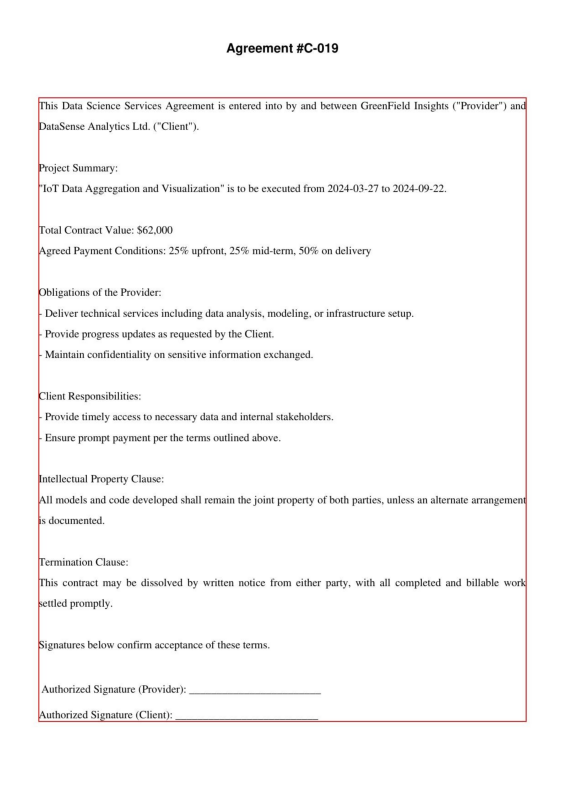

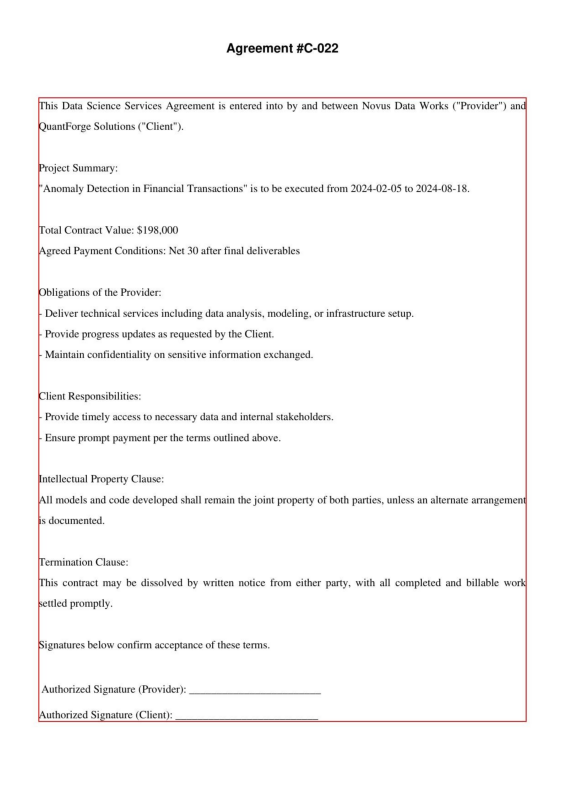

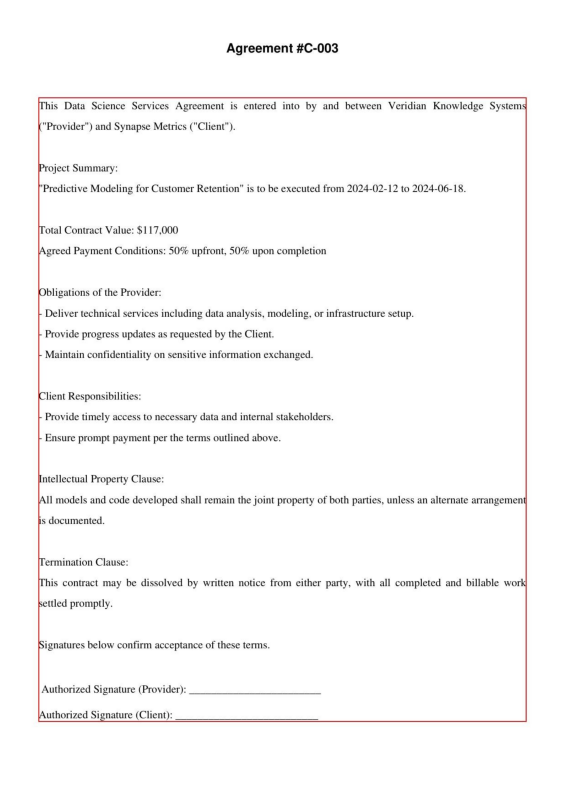

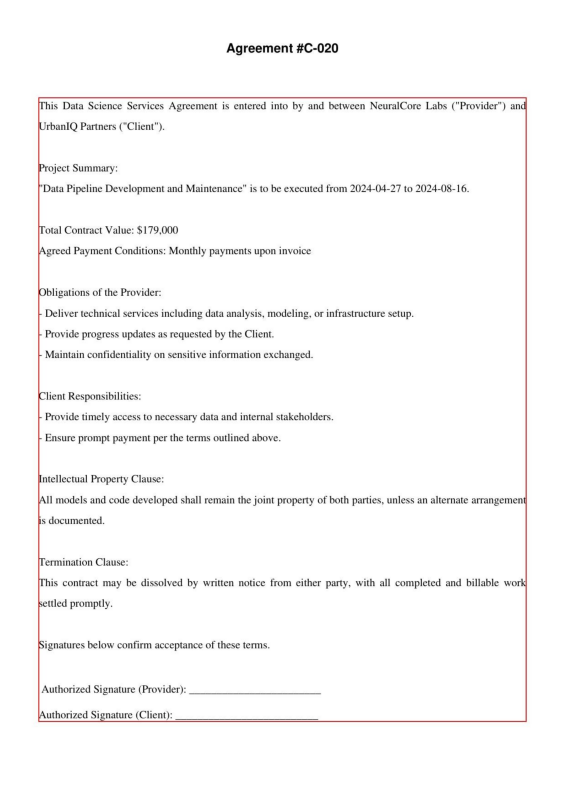

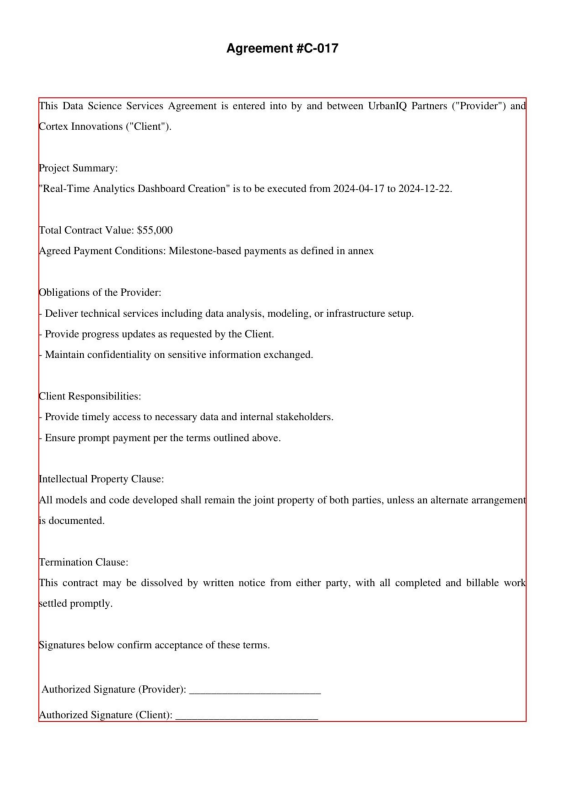

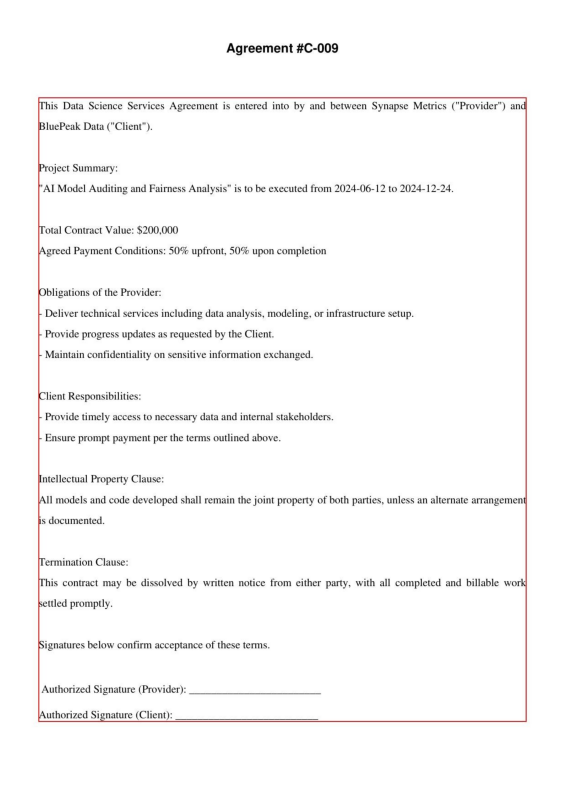

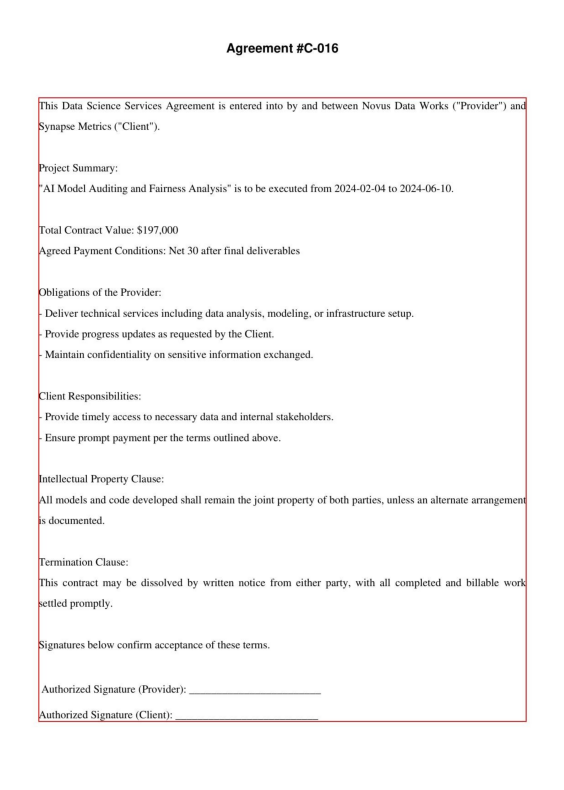

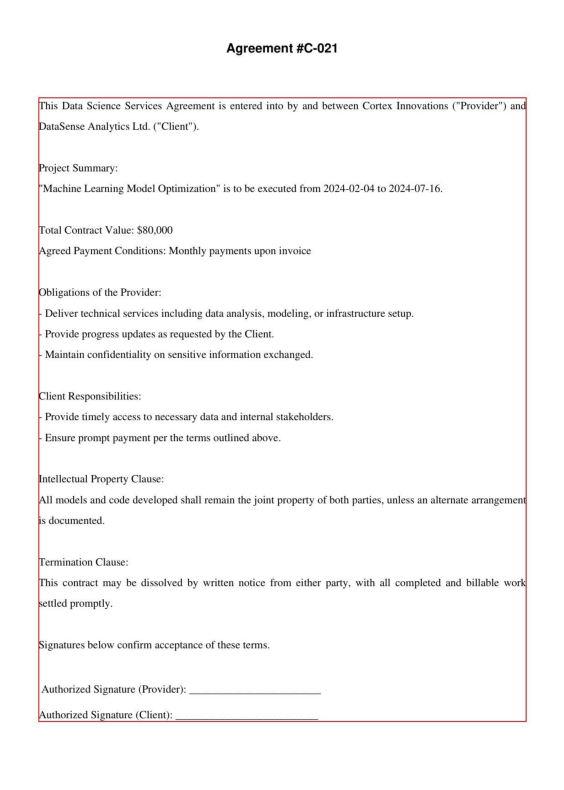

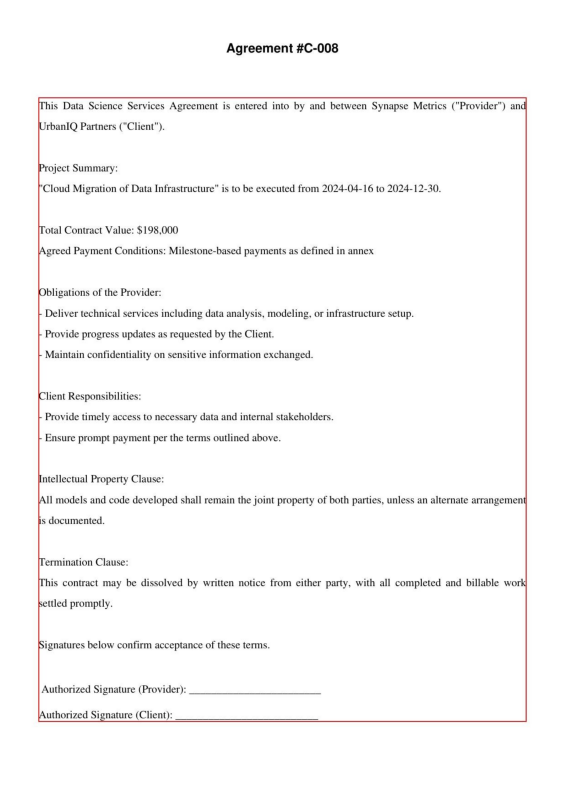

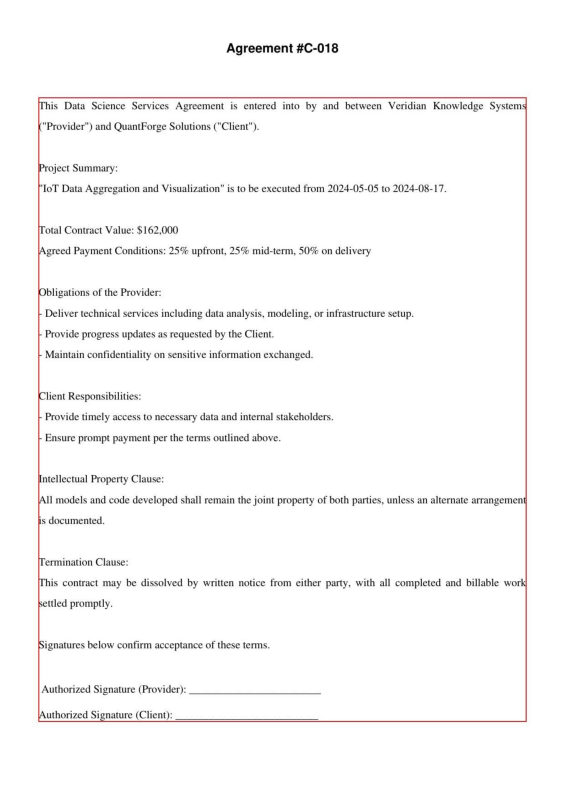

In [ ]:
contents = query_result.retrieval_contents

context = client.agents.query.retrieval_info(
    message_id=query_result.message_id,
    agent_id=agent_id,
    content_ids=[
        [content.content_id for content in query_result.retrieval_contents]
    ],
)
logger.debug(f"\nRetrieval Info: {context}")

for metadata in context.content_metadatas:
    if metadata.page_img:
        img = display_base64_image(metadata.page_img)


In [62]:
with open("contracts_ground_truth.csv", "rb") as f:
    eval_result = client.agents.evaluate.create(
        agent_id=agent_id, 
        metrics=["equivalence", "groundedness"],
        evalset_file=f
    )


In [71]:
eval_status = client.agents.evaluate.jobs.metadata(
    agent_id=agent_id, job_id=eval_result.id
)
logger.info(f"Evaluation Status: {eval_status.status}")


INFO:__main__:Evaluation Status: completed


In [ ]:
import pandas as pd
def process_binary_evaluation(binary_response):
    """
    Process BinaryAPIResponse into a pandas DataFrame.

    Args:
        binary_response: BinaryAPIResponse from evaluate.retrieve

    Returns:
        pd.DataFrame: Processed evaluation data
    """
    # Read the binary content
    content = binary_response.read()

    # Now decode the content
    lines = content.decode("utf-8").strip().split("\n")

    # Parse each line and flatten the results
    data = []
    for line in lines:
        data.append(json.loads(line))

    return pd.DataFrame(data)


In [ ]:
eval_results = client.agents.datasets.evaluate.retrieve(
    dataset_name=eval_status.dataset_name, agent_id=agent_id
)
df = process_binary_evaluation(eval_results)
df.to_csv("eval_results.csv")
df["factuality_score"] = df["results"].apply(lambda r: r["factuality_v4.5"]["score"])
df["equivalence"] = df["results"].apply(lambda r: r["equivalence"]["score"])


In [ ]:
factuality_mean = df["factuality_score"].mean()
factuality_median = df["factuality_score"].median()
factuality_std = df["factuality_score"].std()
factuality_min = df["factuality_score"].min()
factuality_max = df["factuality_score"].max()

equivalence_mean = df["equivalence"].mean()
equivalence_median = df["equivalence"].median()
equivalence_std = df["equivalence"].std()
equivalence_min = df["equivalence"].min()
equivalence_max = df["equivalence"].max()

import pandas as pd

# Create a summary DataFrame
summary = pd.DataFrame(
    {
        "Metric": ["Factuality Score", "Equivalence"],
        "Mean": [factuality_mean, equivalence_mean],
        "Median": [factuality_median, equivalence_median],
        "Std Dev": [factuality_std, equivalence_std],
        "Min": [factuality_min, equivalence_min],
        "Max": [factuality_max, equivalence_max],
    }
)

# Set Metric as index for a cleaner look
summary.set_index("Metric", inplace=True)

# Display as a table (will render nicely in Jupyter/VS Code)
display(summary)


,Mean,Median,Std Dev,Min,Max
Metric,,,,,
Factuality Score,0.433832,0.0,0.480174,0.0,1.0
Equivalence,0.336364,0.0,0.474627,0.0,1.0


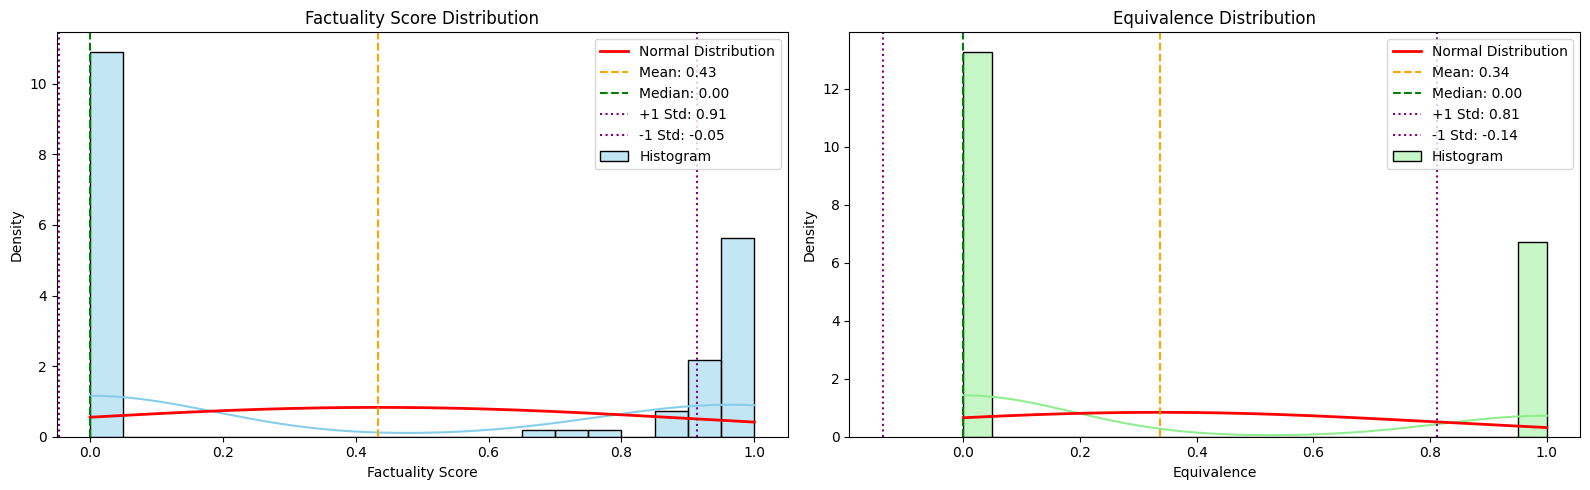

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def plot_score_distributions_with_stats(df):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Factuality Score
    mu_f = df["factuality_score"].mean()
    median_f = df["factuality_score"].median()
    sigma_f = df["factuality_score"].std()
    x_f = np.linspace(df["factuality_score"].min(), df["factuality_score"].max(), 200)
    p_f = np.exp(-((x_f - mu_f) ** 2) / (2 * sigma_f**2)) / (
        sigma_f * np.sqrt(2 * np.pi)
    )

    sns.histplot(
        df["factuality_score"],
        kde=True,
        stat="density",
        bins=20,
        color="skyblue",
        ax=axes[0],
        label="Histogram",
    )
    axes[0].plot(x_f, p_f, "r", linewidth=2, label="Normal Distribution")
    axes[0].axvline(mu_f, color="orange", linestyle="--", label=f"Mean: {mu_f:.2f}")
    axes[0].axvline(
        median_f, color="green", linestyle="--", label=f"Median: {median_f:.2f}"
    )
    axes[0].axvline(
        mu_f + sigma_f,
        color="purple",
        linestyle=":",
        label=f"+1 Std: {(mu_f + sigma_f):.2f}",
    )
    axes[0].axvline(
        mu_f - sigma_f,
        color="purple",
        linestyle=":",
        label=f"-1 Std: {(mu_f - sigma_f):.2f}",
    )
    axes[0].set_title("Factuality Score Distribution")
    axes[0].set_xlabel("Factuality Score")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    # Equivalence
    mu_e = df["equivalence"].mean()
    median_e = df["equivalence"].median()
    sigma_e = df["equivalence"].std()
    x_e = np.linspace(df["equivalence"].min(), df["equivalence"].max(), 200)
    p_e = np.exp(-((x_e - mu_e) ** 2) / (2 * sigma_e**2)) / (
        sigma_e * np.sqrt(2 * np.pi)
    )

    sns.histplot(
        df["equivalence"],
        kde=True,
        stat="density",
        bins=20,
        color="lightgreen",
        ax=axes[1],
        label="Histogram",
    )
    axes[1].plot(x_e, p_e, "r", linewidth=2, label="Normal Distribution")
    axes[1].axvline(mu_e, color="orange", linestyle="--", label=f"Mean: {mu_e:.2f}")
    axes[1].axvline(
        median_e, color="green", linestyle="--", label=f"Median: {median_e:.2f}"
    )
    axes[1].axvline(
        mu_e + sigma_e,
        color="purple",
        linestyle=":",
        label=f"+1 Std: {(mu_e + sigma_e):.2f}",
    )
    axes[1].axvline(
        mu_e - sigma_e,
        color="purple",
        linestyle=":",
        label=f"-1 Std: {(mu_e - sigma_e):.2f}",
    )
    axes[1].set_title("Equivalence Distribution")
    axes[1].set_xlabel("Equivalence")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


# Call the function
plot_score_distributions_with_stats(df)


In [ ]:
# Filter for results with equivalence score of 0.0
zero_score_results = df[
    df["results"].apply(lambda x: x.get("equivalence", {}).get("score") == 0.0)
]
pd.set_option("display.max_colwidth", None)
display(zero_score_results)


,prompt,reference,response,guideline,knowledge,results,status,factuality_score,equivalence
0,What is contract value of contract data/contract_C-022.pdf?,The contract value is None,"Key Contract Details for Agreement #C-022:Total Contract Value: $198,000[2]()Payment Terms:- Net 30 payment schedule after final deliverables[2]()Project Duration: February 5, 2024 to August 18, 2024[2]()For your reference, here are the key parties involved in this contract:Parties to the Agreement:- Provider: Novus Data Works- Client: QuantForge Solutions[2]()Additional contract details are available if needed regarding obligations, intellectual property, and termination clauses.",,"[Document Title: contract_C-022.pdf\nSection: Agreement #C-022\n\n\nDate: ____________________, Document Title: contract_C-022.pdf\n\n This Data Science Services Agreement is entered into by and between Novus Data Works (""Provider"") and QuantForge Solutions (""Client""). Project Summary: ""Anomaly Detection in Financial Transactions"" is to be executed from 2024-02-05 to 2024-08-18. Total Contract Value: $198,000 Agreed Payment Conditions: Net 30 after final deliverables Obligations of the Provider: - - Deliver technical services including data analysis, modeling, or infrastructure setup.\n - Provide progress updates as requested by the Client. - - Maintain confidentiality on sensitive information exchanged.\n Client Responsibilities: - - Provide timely access to necessary data and internal stakeholders.\n- - Ensure prompt payment per the terms outlined above.\n Intellectual Property Clause: All models and code developed shall remain the joint property of both parties, unless an alternate arrangement is documented. Termination Clause: This contract may be dissolved by written notice from either party, with all completed and billable work settled promptly. Signatures below confirm acceptance of these terms. Authorized Signature (Provider): ________________________ Authorized Signature (Client): __________________________]","{'factuality_v4.5': {'score': 1.0, 'metadata': {'claim_scores': [{'score': 'Supported', 'claim': 'The total contract value for Agreement #C-022 is $198,000.'}, {'score': 'Supported', 'claim': 'The payment schedule for Agreement #C-022 is Net 30 after final deliverables.'}, {'score': 'Supported', 'claim': 'The project duration for Agreement #C-022 is from February 5, 2024 to August 18, 2024.'}, {'score': 'Supported', 'claim': 'The provider for Agreement #C-022 is Novus Data Works.'}, {'score': 'Supported', 'claim': 'The client for Agreement #C-022 is QuantForge Solutions.'}, {'score': 'Supported', 'claim': 'Additional contract details are available regarding obligations, intellectual property, and termination clauses for Agreement #C-022.'}]}}, 'equivalence': {'score': 0.0, 'metadata': 'The generated response provides a contract value of $198,000, whereas the reference response states the contract value is None, indicating a fundamental difference in core information.'}}",completed,1.000000,0.0
3,What is the start date of the contract data/contract_C-022.pdf?,The start date of the contract is 2024-02-05,"The contract's project execution period is specified as February 5, 2024 to August 18, 2024.[1]() However, the document signing date field remains blank in the provided contract.[2]()Based on the available information, I cannot definitively state the contract's effective start date, as this would typically be the date when both parties have signed the agreement. The project execution dates mentioned are part of the project scope but do not necessarily indicate when the contract itself became effective.",,"[Document Title: contract_C-022.pdf\n\n This Data Science Services Agreement is entered into by and between Novus Data Works (""Provider"") and QuantForge Solutions (""Client""). Project Summary: ""Anomaly Detection in Financial Transactions"" is to be executed from 2024-02-05 to 2024-08-18. Total Contract Value: $198,000 Agreed Payment Conditions: 